In [2]:
import pandas as pd
import numpy as np
import glob
import soundfile
import os
import sys

In [3]:
import librosa
import librosa.display
import seaborn as sbn
import matplotlib.pyplot as plt
from sklearn import metrics

C:\Users\HP\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [4]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import scipy

In [5]:
from IPython.display import Audio

In [6]:
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore",category=DeprecationWarning)    

In [7]:
RavdessData="C:\\Users\\HP\\Downloads\\archive (3)-20230206T071458Z-001\\archive (3)\\audio_speech_actors_01-24\\"

In [8]:
ravdessDirectoryList=os.listdir(RavdessData)
fileEmotion=[]
filepath=[]
for dir in ravdessDirectoryList:
    actor=os.listdir(RavdessData+dir)
    for file in actor:
        part=file.split('.')[0]
        part=part.split('-')
        fileEmotion.append(int(part[2]))
        filepath.append(RavdessData+dir+'/'+file)
emotion_df=pd.DataFrame(fileEmotion,columns=['Emotions']) 
path_df=pd.DataFrame(filepath,columns=['Path'])
Ravdess_df=pd.concat([emotion_df,path_df],axis=1)

In [9]:
Ravdess_df.Emotions=Ravdess_df.Emotions.replace({1:'neutral',2:'calm',3:'happy',4:'sad',5:'angry',6:'fear',7:'disgust',8:'suprised'})

In [10]:
datapath=pd.concat([Ravdess_df],axis=0)
datapath.to_csv("data_path.csv",index=False)
datapath.head()

,Emotions,Path
0,neutral,C:\Users\HP\Downloads\archive (3)-20230206T071...
1,neutral,C:\Users\HP\Downloads\archive (3)-20230206T071...
2,neutral,C:\Users\HP\Downloads\archive (3)-20230206T071...
3,neutral,C:\Users\HP\Downloads\archive (3)-20230206T071...
4,calm,C:\Users\HP\Downloads\archive (3)-20230206T071...


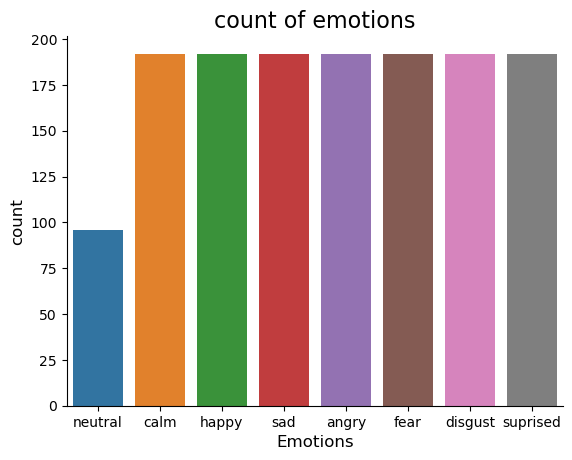

In [11]:
plt.title('count of emotions',size=16)
sbn.countplot(datapath.Emotions)
plt.ylabel('count',size=12)
plt.xlabel('Emotions',size=12)
sbn.despine(top=True,right=True,left=False,bottom=False)
plt.show()

In [12]:
def createWaveplot(data,sr,e):
    plt.figure(figsize=(10,3))
    plt.title('Waveplot for audio with {} emotion'.format(e),size=15)
    librosa.display.waveshow(data,sr=sr)
    plt.show()

In [13]:
def createSpectogram(data,sr,e):
    x=librosa.stft(data)
    xdb=librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(12,3))
    plt.title('spectogram for audio with {} emotion'.format(e),size=15)
    librosa.display.specshow(xdb,sr=sr,x_axis='time',y_axis='hz')
    plt.colorbar()


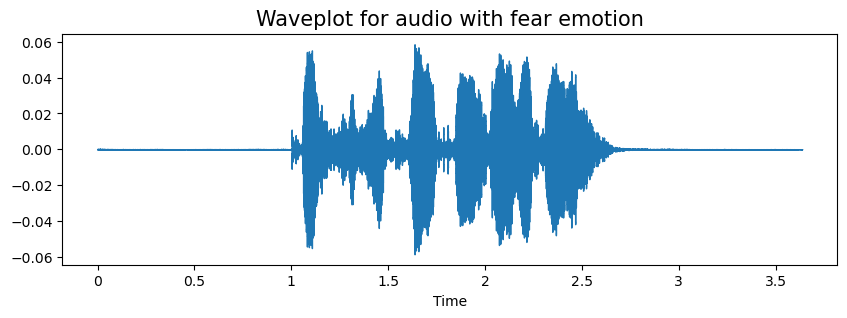

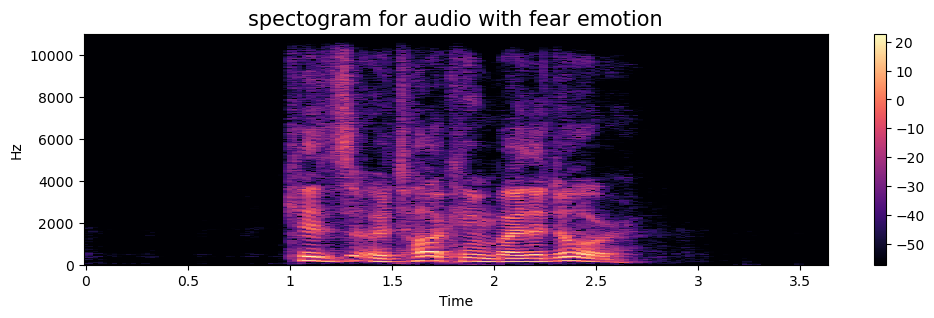

In [14]:
emotion='fear'
path=np.array(datapath.Path[datapath.Emotions==emotion])[1]
data,samplingRate=librosa.load(path)
createWaveplot(data,samplingRate,emotion)
createSpectogram(data,samplingRate,emotion)
Audio(path)

In [16]:
def noise(data):
    noiseAmp=0.035*np.random.uniform()*np.amax(data)
    data=data+noiseAmp*np.random.normal(size=data.shape[0])
    return data
def stretch(data,rate=0.8):
    return librosa.effects.time_stretch(data,rate)
def shift(data):
    shiftRange=int(np.random.uniform(low=5,high=5)*1000)
    return np.roll(data,shiftRange)
def pitch(data,samplingRate,pitchFactor=0.7):
    return librosa.effects.pitch_shift(data,samplingRate,pitchFactor)

In [17]:
path=np.array(datapath.Path)[1]
data,sampleRate=librosa.load(path)


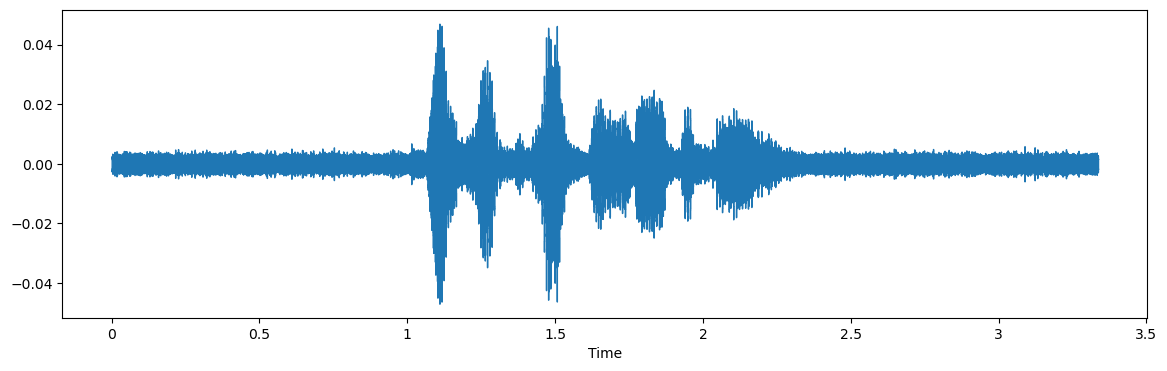

In [18]:
x=noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x,sr=sampleRate)
Audio(x,rate=sampleRate)

In [19]:
def extractFeature(fileName,mfcc,chroma,mel):
    with soundfile.SoundFile(fileName) as soundFile:
        X=soundFile.read(dtype="float32")
        sampleRate=soundFile.samplerate
        if mfcc:
            mfccs=librosa.feature.mfcc(y=X,sr=sampleRate,n_mfcc=40)
        if chroma:
            chroma=librosa.feature.chroma_stft(y=X,sr=sampleRate)
        if mel:
            mel=librosa.feature.melspectrogram(X,sr=sampleRate)
        features=[np.mean(mfccs.ravel()),np.mean(chroma.ravel()),np.mean(mel.ravel())]    
    return features

In [20]:
emotions={
    '01':'fear',
    '02':'calm',
    '03':'happy',
    '04':'sad',
    '05':'angry',
    '06':'neutral',
    '07':'disgust',
    '08':'suprised'
}
observedEmotions=['calm','happy','neutral','disgust']

In [21]:
def loaddata(test_size=0.2):
    x,y=[],[]
    for file in glob.glob("C:\\Users\\HP\\Downloads\\archive (3)-20230206T071458Z-001\\archive (3)\\Actor_*\\*.wav"):
        fileName=os.path.basename(file)
        emotion1=emotions[fileName.split("-")[2]]
        if emotion1 not in observedEmotions:
            continue
        feature=extractFeature(file,mfcc=True,chroma=True,mel=True)
        x.append(np.mean(feature))
        y.append(emotion1)
    return train_test_split(np.array(x),y,test_size=test_size,random_state=9)    

In [22]:
xTrain,xTest,yTrain,yTest=loaddata(test_size=0.23)

In [23]:
print(xTrain.shape[0],xTest.shape[0])

592 177


In [47]:
model=MLPClassifier(alpha=0.01,batch_size=256,epsilon=1e-08,learning_rate='adaptive', max_iter=500)

In [25]:
xTrain=np.reshape(xTrain,(592,-1))
xTest=np.reshape(xTest,(177,-1))

In [26]:
model.fit(xTrain,yTrain)

MLPClassifier(alpha=0.01, batch_size=256, learning_rate='adaptive',
              max_iter=500)

In [27]:
import pickle

In [28]:
pickle.dump(model,open('model.pkl','wb'))
speech_model=pickle.load(open('model.pkl','rb'))

In [ ]:
!pip install pyaudio

In [49]:
import pyaudio
import numpy as np
import wave
import time

# Set the parameters for the recording
CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 2
RATE = 44100
RECORD_SECONDS = 10
WAVE_OUTPUT_FILENAME = "C:\\Users\\HP\\Downloads\\archive (3)-20230206T071458Z-001\\archive (3)\\audio_test5.wav"

# Initialize the PyAudio object
p = pyaudio.PyAudio()

# Start the stream
stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

print("* recording")

frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    # Read audio data from the stream
    audio = stream.read(CHUNK)
    frames.append(audio)

print("* done recording")

# Stop the stream
stream.stop_stream()
stream.close()
p.terminate()

# Save the audio to a wave file
wf = wave.open(WAVE_OUTPUT_FILENAME, "wb")
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b"".join(frames))
wf.close()

* recording
* done recording


In [46]:
import librosa
import numpy as np

# Load the audio file
filename = "C:\\Users\\HP\\Downloads\\archive (3)-20230206T071458Z-001\\archive (3)\\audio_test.wav"
# Segment the audio into frames
audio, sr = librosa.load(filename, sr=None)
audio = librosa.util.normalize(audio)
audio=np.reshape(audio,(audio.shape[0],-1))

# Make a prediction using the model
prediction=speech_model.predict(audio)
print(prediction)


# Preprocess the audio

['neutral' 'neutral' 'neutral' ... 'neutral' 'neutral' 'neutral']


In [33]:
a=Audio('C:\\Users\\HP\\Downloads\\archive (3)-20230206T071458Z-001\\archive (3)\\audio_speech_actors_01-24\\Actor_01\\03-01-02-01-01-01-01.wav')
a

In [40]:
datapath

,Emotions,Path
0,neutral,C:\Users\HP\Downloads\archive (3)-20230206T071...
1,neutral,C:\Users\HP\Downloads\archive (3)-20230206T071...
2,neutral,C:\Users\HP\Downloads\archive (3)-20230206T071...
3,neutral,C:\Users\HP\Downloads\archive (3)-20230206T071...
4,calm,C:\Users\HP\Downloads\archive (3)-20230206T071...
...,...,...
1435,suprised,C:\Users\HP\Downloads\archive (3)-20230206T071...
1436,suprised,C:\Users\HP\Downloads\archive (3)-20230206T071...
1437,suprised,C:\Users\HP\Downloads\archive (3)-20230206T071...
1438,suprised,C:\Users\HP\Downloads\archive (3)-20230206T071...
